# Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
predictors = pd.read_csv('../data/water_table_training.csv')
target = pd.read_csv('../data/water_table_labels.csv')

In [3]:
df = predictors.merge(target, on = 'id')
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [4]:
##selecting which columns to drop based off impact on prediction and overlapping information
columns = ['id', 'date_recorded', 'installer', 'wpt_name', 'num_private', 'region', 'subvillage', 
           'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'water_quality', 
           'quantity', 'source_type', 'waterpoint_type_group', 'public_meeting']

In [5]:
cleaned_df = df.drop(columns = columns, axis = 1)
cleaned_df.dropna(inplace = True)

cleaned_df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'population',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

In [6]:
#sns.pairplot(cleaned_df[numerical_columns])

count    51329.000000
mean      1334.765552
std        940.138379
min          0.000000
25%          0.000000
50%       1987.000000
75%       2005.000000
max       2013.000000
Name: construction_year, dtype: float64 
Mode: 0    2008.0
dtype: float64


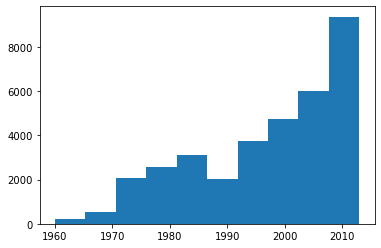

In [7]:
##checking to see distribution of non-zero(np.nan) values to determine how to impute
## will impute with mode

print(cleaned_df.construction_year.describe(), '\nMode:', cleaned_df.construction_year.replace(0.0, np.nan).mode())
plt.hist(cleaned_df.construction_year.replace(0.0, np.nan));

In [8]:
cleaned_df.construction_year.replace(0.0, np.nan, inplace = True)

In [9]:
#replacing string values for status group with 0, 1, or 2 in 'status_no'

conditions = [cleaned_df['status_group'] == 'non functional', cleaned_df['status_group'] == 'functional needs repair', cleaned_df['status_group'] == 'functional']
choices = [0,1,2]

cleaned_df['status_no'] = np.select(conditions, choices)
cleaned_df.drop('status_group', axis = 1, inplace = True)


# Some Vanilla Models

## First Model with Cleaned Data - Logistic Regression

In [10]:
cleaned_df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'population',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'status_no'],
      dtype='object')

In [11]:
##Separating predictor feature columns into categorical and continuous value groups

#continuous features
numerical_columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

#categorical features without the target of 'status_group'
categorical_columns = cleaned_df.select_dtypes(include = 'object').columns

categoricals1 = ['funder', 'basin', 'lga', 'extraction_type', 'management', 'source']
categoricals2 = ['region_code', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'quality_group', 'quantity_group']


## high number of categorical features has been computationally hard so this is a fallback option for now
smaller_columns_list = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year', 'region_code', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'quality_group', 'quantity_group']

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

X = cleaned_df[smaller_columns_list]
y = cleaned_df['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [13]:
X_train_cats = X_train[categoricals2]
X_train_nums = X_train[numerical_columns]

X_test_cats = X_test[categoricals2]
X_test_nums = X_test[numerical_columns]

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [14]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train))
X_train_imputed.columns = X_train.columns

In [15]:
ohe_train = OneHotEncoder(drop = 'first', sparse = False)

ohe_train.fit(X_train_cats)

X_train_enc = pd.DataFrame(ohe_train.transform(X_train_cats))

In [16]:
X_train_imputed.drop(columns = X_train_cats.columns, inplace = True)
X_train_transformed = pd.concat([X_train_imputed, X_train_enc], axis = 1)

In [17]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train_transformed)
X_train_scaled

array([[-0.14573364, -0.99559951, -0.12984523, ..., -0.56725832,
        -0.25084539, -0.0828591 ],
       [-0.13675601, -0.99559951,  0.46797739, ..., -0.56725832,
         3.98651936, -0.0828591 ],
       [-0.14348924,  0.59769698,  0.47480398, ..., -0.56725832,
        -0.25084539, -0.0828591 ],
       ...,
       [-0.14259147,  1.00896304,  0.47005004, ..., -0.56725832,
        -0.25084539, -0.0828591 ],
       [-0.12328957, -0.78277651,  0.72199371, ..., -0.56725832,
        -0.25084539, -0.0828591 ],
       [ 0.07870706,  2.11909381,  0.06052326, ...,  1.7628653 ,
        -0.25084539, -0.0828591 ]])

In [18]:
logreg_larj = LogisticRegression(random_state=2021, max_iter=1200)
logreg_larj.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1200, random_state=2021)

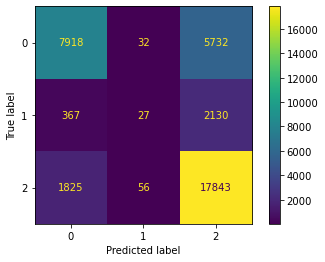

In [19]:
plot_confusion_matrix(logreg_larj, X_train_scaled, y_train)

In [20]:
print("Score:", logreg_larj.score(X_train_scaled, y_train))
#print("3-fold cross-val score:" , cross_val_score(logreg_larj, X_train_scaled, y_train))

Score: 0.7177289173392708


In [21]:
larj_precision0 = 7918/(7918+367+1825) #precision of 'non-functional' predictions
larj_precision1 = 27/(32+27+56) #precision of 'needs repairs' predictions
larj_precision2 = 17843/(17843+5732+2130) #precision of 'functional' predictions

larj_precision0, larj_precision1, larj_precision2, (larj_precision0+larj_precision1+larj_precision2)/3

(0.7831849653808111,
 0.23478260869565218,
 0.6941451079556507,
 0.570704227344038)

Average accuracy and average precision are roughly the same, but it looks like this first model is having a hard time correctly predicting target 1, which is 'functional needs repair.' Could be due to class imbalance.

## Second Model - K Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [23]:
knn.score(X_train_scaled, y_train)

0.8207069301419426

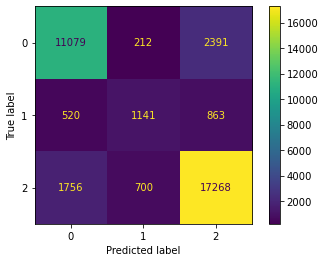

In [24]:
plot_confusion_matrix(knn, X_train_scaled, y_train)

In [25]:
knn_precision0 = 11079/(11079+520+1756) #precision of 'non-functional' predictions
knn_precision1 = 1141/(212+1141+700) #precision of 'needs repairs' predictions
knn_precision2 = 17268/(17268+2391+863) #precision of 'functional' predictions

knn_precision0, knn_precision1, knn_precision2, (knn_precision0+knn_precision1+knn_precision2)/3

(0.8295769374766006,
 0.5557720409157331,
 0.8414384562908098,
 0.7422624782277145)

## Third Model - Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(X_train_scaled, y_train)
tree.score(X_train_scaled, y_train)

0.9921792374060674

In [27]:
cross_val_score(tree, X_train_scaled, y_train, cv = 5)

array([0.73754523, 0.73448372, 0.73476204, 0.74993042, 0.74533816])

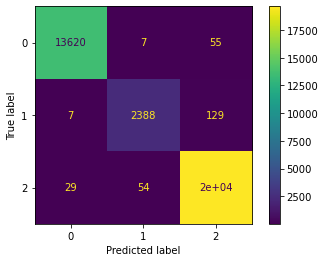

In [28]:
plot_confusion_matrix(tree, X_train_scaled, y_train)

In [29]:
tree_precision0 = 13620/(13620+7+29) #precision of 'non-functional' predictions
tree_precision1 = 2388/(2388+7+54) #precision of 'needs repairs' predictions
tree_precision2 = 20000/(20000+55+129) #precision of 'functional' predictions

tree_precision0, tree_precision1, tree_precision2, (tree_precision0+tree_precision1+tree_precision2)/3

(0.9973637961335676,
 0.9750918742343814,
 0.9908838684106223,
 0.9877798462595239)

## Transforming X_test the same way as X_train

In [30]:
X_test_no_transforms = X_test.copy()

In [31]:
X_test_imputed = pd.DataFrame(imputer.transform(X_test))
X_test_imputed.columns = X_test.columns


ohe_train.fit(X_test_cats)

X_test_enc = pd.DataFrame(ohe_train.transform(X_test_cats))
X_test_imputed.drop(columns = X_test_cats.columns, inplace = True)
X_test_transformed = pd.concat([X_test_imputed, X_test_enc], axis = 1)

X_test_scaled = ss.transform(X_test_transformed)

## Predicting on the test set

In [32]:
y_preds = tree.predict(X_test_scaled)

In [33]:
tree.score(X_test_scaled, y_test)

0.7516072472238458

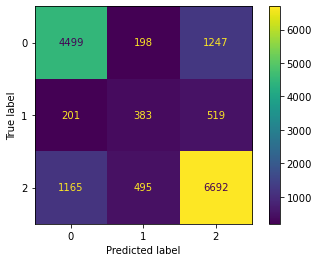

In [34]:
plot_confusion_matrix(tree, X_test_scaled, y_test)

In [35]:
treetest_precision0 = 4499/(4499+201+1165) #precision of 'non-functional' predictions
treetest_precision1 = 383/(198+383+495) #precision of 'needs repairs' predictions
treetest_precision2 = 6692/(6692+1247+519) #precision of 'functional' predictions

treetest_precision0, treetest_precision1, treetest_precision2, (treetest_precision0+treetest_precision1+treetest_precision2)/3

(0.7670929241261722,
 0.3559479553903346,
 0.7912035942303145,
 0.6380814912489404)

Indicator that this model is very overfit but potentially a good candidate for hyperparameter tuning.  
Target 1 is a concern.